### Questions
1. Answer the following questions. For each question, please provide the code that you used to analyze the data and generate your results. We're really interested in understanding your thought process; please explain your motivation for using any specific algorithm/tool/library.
a. What are the top features that affect the time to resolve a complaint? Do they change over time?
b. Are rat sightings more common in areas that have a higher density of restaurants with low inspection grades?

2. Additional Questions:
a. Ask 2 additional questions you would like to answer with this data.
b. For each question, briefly discuss which additional data would be necessary, as well as how you would tackle it.
c. Select one of your questions and dive deeper!

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import operator
import warnings; warnings.simplefilter('ignore')
from pandas.io.gbq import read_gbq
from scipy.stats import linregress
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Lasso, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

## 1. What are the top features that affect the time to resolve a complaint? Do they change over time?

### Instead of using the curl method for data importation, I'm using the same data stored in a Google Big Query database and the google api tool to import that data. This is much more convenient and useful than a 16GB file download. With this method, I can reduce the importation size of the data with a targeted SQL query, only working with the features that are important to solving this problem. This also allows me to run this locally instead of paying for cloud computing.

In [3]:
#let's see how large the dataset is - 16,983,314 rows

project = "spheric-crow-161317"
sample_query = "SELECT count(*) FROM `bigquery-public-data.new_york.311_service_requests`"
g= read_gbq(query=sample_query, project_id=project, dialect='standard')
g

Requesting query... ok.
Job ID: job_CwbduPk7F1ZEFonM0vSHSz-PNVKv
Query running...
Query done.
Processed: 0.0 B
Standard price: $0.00 USD

Retrieving results...
Got 1 rows.

Total time taken 1.54 s.
Finished at 2018-03-07 16:35:31.


,f0_
0,16983314


In [41]:
#sample import of 311 data

project = "spheric-crow-161317"
sample_query = "SELECT * FROM `bigquery-public-data.new_york.311_service_requests` LIMIT 100"

df = read_gbq(query=sample_query, project_id=project, dialect='standard')

Requesting query... ok.
Job ID: job_lQ3bAizJD7XLBJcsn80Ch7lowxDn
Query running...
Query done.
Cache hit.

Retrieving results...
Got 100 rows.

Total time taken 1.14 s.
Finished at 2018-03-07 17:45:42.


In [42]:
df.head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,...,bridge_highway_name,bridge_highway_direction,road_ramp,bridge_highway_segment,garage_lot_name,ferry_direction,ferry_terminal_name,latitude,longitude,location
0,35382611,2017-01-25 00:00:00,2017-01-31 00:00:00,DEP,Department of Environmental Protection,ATF,,,11375,67-36 KESSEL STREET,...,,,,,,,,40.716019,-73.856598,"(40.71601881415676, -73.85659819275682)"
1,24891292,2013-01-29 11:51:00,2013-01-31 17:00:00,DEP,Department of Environmental Protection,ATF,,,11377,,...,,,,,,,,40.742685,-73.895653,"(40.742684984899114, -73.89565260528727)"
2,36034528,2016-05-05 00:00:00,2016-05-06 13:00:00,DEP,Department of Environmental Protection,ATF,,,11378,58-03 GRAND AVENUE,...,,,,,,,,40.719675,-73.911168,"(40.71967498126572, -73.91116849445618)"
3,36975822,2017-08-09 00:00:00,NaT,DEP,Department of Environmental Protection,ATF,,,11427,86-10 SPRINGFIELD BOULEVARD,...,,,,,,,,40.731235,-73.746358,"(40.73123510559856, -73.7463580523228)"
4,32560181,2016-01-27 00:00:00,2016-02-01 00:00:00,DEP,Department of Environmental Protection,FATF,,,11368,96-05 HORACE HARDING EXPRESSWAY,...,,,,,,,,40.734382,-73.864309,"(40.734382374301646, -73.8643093383117)"


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 53 columns):
unique_key                        100 non-null int64
created_date                      100 non-null datetime64[ns]
closed_date                       85 non-null datetime64[ns]
agency                            100 non-null object
agency_name                       100 non-null object
complaint_type                    100 non-null object
descriptor                        100 non-null object
location_type                     100 non-null object
incident_zip                      100 non-null object
incident_address                  100 non-null object
street_name                       100 non-null object
cross_street_1                    100 non-null object
cross_street_2                    100 non-null object
intersection_street_1             100 non-null object
intersection_street_2             100 non-null object
address_type                      100 non-null object
city              

### We only want cases that are closed, so we'll reduce data accordingly

In [46]:
#looking at overall side of closed cases without null closed dates: 15,909,157

project = "spheric-crow-161317"
sample_query = "SELECT count(*) FROM `bigquery-public-data.new_york.311_service_requests` WHERE status IN ('Closed') AND closed_date IS NOT NULL"
g= read_gbq(query=sample_query, project_id=project, dialect='standard')
g

Requesting query... ok.
Job ID: job_CvqQ-IkujoRo_hTwII8fIRlTDtzc
Query running...
Query done.
Processed: 254.7 MB
Standard price: $0.00 USD

Retrieving results...
Got 1 rows.

Total time taken 1.76 s.
Finished at 2018-03-07 17:47:09.


,f0_
0,15909157


In [47]:
#looking at maximum and minimum dates

project = "spheric-crow-161317"
sample_query = "SELECT min(created_date), max(created_date) FROM `bigquery-public-data.new_york.311_service_requests` WHERE status IN ('Closed') AND closed_date IS NOT NULL"
g= read_gbq(query=sample_query, project_id=project, dialect='standard')
g

Requesting query... ok.
Job ID: job_ABqWIm_1CSG-bVxFEXA_HDgxlBtO
Query running...
Query done.
Processed: 384.3 MB
Standard price: $0.00 USD

Retrieving results...
Got 1 rows.

Total time taken 1.8 s.
Finished at 2018-03-07 17:47:46.


,f0_,f1_
0,2010-01-01,2018-01-24 01:59:47


#### The data is up to date; starts in January 2010 and goes until late January 2018.

In [48]:
#querying data by the year, 2010

project = "spheric-crow-161317"
sample_query = "SELECT created_date, closed_date, agency, complaint_type, descriptor, incident_zip, borough, city, location_type FROM `bigquery-public-data.new_york.311_service_requests` WHERE status IN ('Closed') AND closed_date IS NOT NULL AND created_date BETWEEN '2010-01-01' and '2011-01-01'"

df = read_gbq(query=sample_query, project_id=project, dialect='standard')

Requesting query... ok.
Job ID: job_uhitbrtDlvrzZgyzbmX2fHnFHEP2
Query running...
  Elapsed 11.14 s. Waiting...
Query done.
Processed: 1.7 GB
Standard price: $0.01 USD

Retrieving results...
  Got page: 1; 2.0% done. Elapsed 22.48 s.
  Got page: 2; 4.0% done. Elapsed 26.97 s.
  Got page: 3; 6.0% done. Elapsed 31.9 s.
  Got page: 4; 8.0% done. Elapsed 36.48 s.
  Got page: 5; 10.0% done. Elapsed 41.65 s.
  Got page: 6; 12.0% done. Elapsed 46.67 s.
  Got page: 7; 14.0% done. Elapsed 51.89 s.
  Got page: 8; 17.0% done. Elapsed 57.31 s.
  Got page: 9; 19.0% done. Elapsed 61.83 s.
  Got page: 10; 21.0% done. Elapsed 67.31 s.
  Got page: 11; 23.0% done. Elapsed 72.36 s.
  Got page: 12; 25.0% done. Elapsed 76.68 s.
  Got page: 13; 27.0% done. Elapsed 81.99 s.
  Got page: 14; 29.0% done. Elapsed 86.75 s.
  Got page: 15; 31.0% done. Elapsed 93.55 s.
  Got page: 16; 33.0% done. Elapsed 98.25 s.
  Got page: 17; 35.0% done. Elapsed 104.36 s.
  Got page: 18; 37.0% done. Elapsed 109.06 s.
  Got page:

In [55]:
#creating resolution_time column, in datetime and in seconds

df['resolution_time'] = df['closed_date'] - df['created_date']
df['resolution_time_sec'] = df['resolution_time'].astype('timedelta64[s]')

#need to get rid of erroneous columns where resolution time is zero or less

df = df[df['resolution_time_sec'] > 0]

#looking at the median time of resolutions

median_time = df['resolution_time_sec'].median()
print("median time in seconds: "+str(median_time))
print("median time in hours: "+str((median_time/60.0)/60.0))

median time in seconds: 345600.0
median time in hours: 96.0


In [56]:
#creating a funcion that separates the resolution time into taking more or less than median time

def median_time_func(x):
    if x >= median_time:
        return 1
    else:
        return 0

#applying the function to the dataframe and creating a target variable    
    
df['resolution'] = df['resolution_time_sec'].map(median_time_func)

In [58]:
#checking to make sure the function worked, and it did

df['resolution'].sum()

934509L

In [59]:
#creating features for day of the week, month, and hour the complaint was made

df['created_month'] = df['created_date'].dt.strftime('%-m').astype(int)
df['created_day'] = df['created_date'].dt.strftime('%w').astype(int)
df['created_hour'] = df['created_date'].dt.strftime('%H').astype(int)

#creating features for year, month, day of the week, month, and hour the complaint was closed

df['closed_month'] = df['closed_date'].dt.strftime('%-m').astype(int)
df['closed_day'] = df['closed_date'].dt.strftime('%w').astype(int)
df['closed_hour'] = df['closed_date'].dt.strftime('%H').astype(int)

In [63]:
#affirming the correct columns are in the dataframe

df = df[['created_date', 'closed_date', 'agency', 'complaint_type',
       'descriptor', 'incident_zip', 'borough', 'city', 'location_type',
       'resolution_time_sec', 'resolution','created_month', 'created_day', 
       'created_hour', 'closed_month','closed_day', 'closed_hour']]

In [64]:
#transforming all of the features into integers

le = LabelEncoder()
df['agency'] = le.fit_transform(df['agency'])
df['complaint_type'] = le.fit_transform(df['complaint_type'])
df['descriptor'] = le.fit_transform(df['descriptor'])
df['incident_zip'] = le.fit_transform(df['incident_zip'])
df['borough'] = le.fit_transform(df['borough'])
df['city'] = le.fit_transform(df['city'])
df['location_type'] = le.fit_transform(df['location_type'])

#float to int

df['resolution_time_sec'] = df['resolution_time_sec'].astype(int)

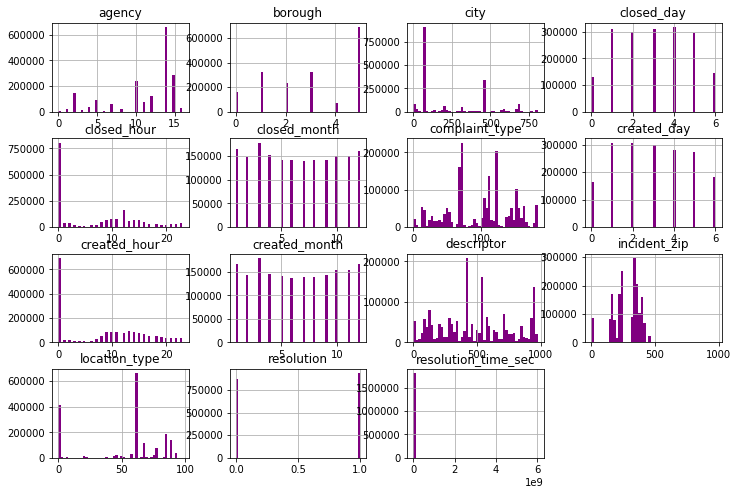

In [65]:
#visualizing distributions

df.hist(bins=50, figsize = (12,8), color = 'purple');

#### Too many complaints at midnight! Looking at the data, it appears that when there isn't an hour listed they list it as 00:00. So we're not going to include created hour as a feature.

#### The distribution of the "city" feature stands out. Digging in, it appears that there are errors, so I'm not going to include it in modeling. (This work is not pictured here for brevity.)

#### The Data isn't normally distributed, so I predict that Ensemble and Tree algorithms are going to do a better job modeling this data than Linear algorithms and will focus algorithms accordingly.

In [66]:
#getting rid of hour features and separating target from the rest of the data for the correlation matrix

y = df.resolution

df = df[['agency', 'complaint_type','descriptor', 'incident_zip', 'borough', 'city', 'location_type',
       'resolution_time_sec', 'created_month', 'created_day', 'closed_month', 'closed_day']]

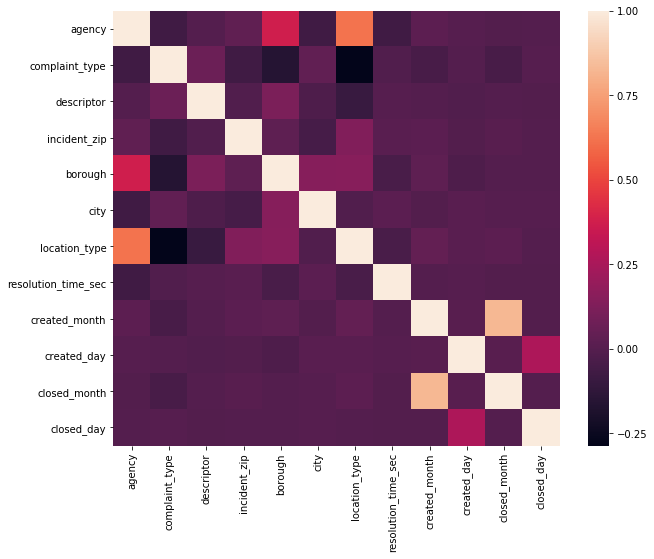

In [67]:
#correlation heatmap to reduce dimensionality

corr = df.corr()
fig, ax = plt.subplots(figsize=(10,8)) 
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values);

### looking at correlations for modeling

- We're not including created hour because that information is pretty erroneous
- Location type and agency is correlated because some agencies only service one location type
- We're eliminating agency, it's correlated with borough and location type
- We're eliminating closed month as it's correlated with created month
- Getting rid of City as it doesn't seem to be a good descriptor, as per the histogram.

In [92]:
#separating into data and target

X = df[['complaint_type', 'descriptor', 'incident_zip','borough', 
        'location_type','created_month', 'created_day']]
y = y

In [93]:
#min max scale and test train split

X = MinMaxScaler().fit_transform(X)

#test train split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [94]:
#choosing a mix of linear, ensemble and tree models that might handle the data well. 
#I'm not optimistic that Linear Algorithms will perform well, but they serve as a good baseline and are
#computationally lighter than the other algorithms here.

models = [LogisticRegression(penalty='l1'),  
          RidgeClassifier(solver="lsqr"),    
          AdaBoostClassifier(),
          DecisionTreeClassifier(),
          RandomForestClassifier(n_jobs=-1),
          ExtraTreesClassifier(n_jobs=-1),
         ]

res = []

for model in models:
    print model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    print score
    res.append([model, score])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.6703522355635049
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='lsqr',
        tol=0.001)
0.669225779090487
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
0.7708968571529148
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
0.8143073382269373
RandomForest

#### As predicted, Ensemble and Tree methods performed the best
#### The goal of this exercise is feature importaces, not making the perfect model. So, I'm going to run the top three performing algorithms to get an understanding of this data's feature importances.

In [95]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
score = dt.score(X_test, y_test)
print score

0.8141849701874577


In [96]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
score = rf.score(X_test, y_test)
print score

0.8255115570746328


In [97]:
et = ExtraTreesClassifier()
et.fit(X_train, y_train)
y_pred = et.predict(X_test)
score = et.score(X_test, y_test)
print score

0.8192054123551489


#### Visualzing the feature importances

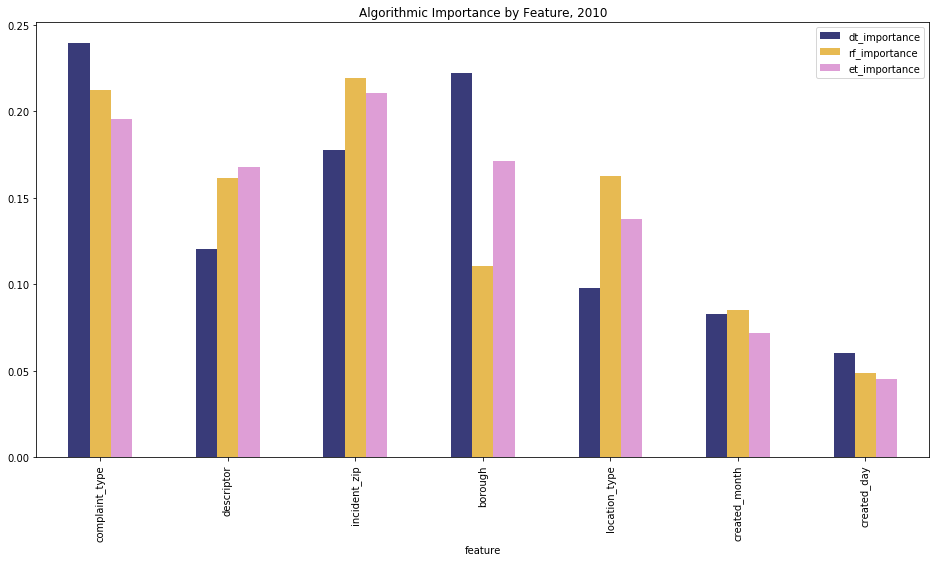

In [99]:
cols=['complaint_type', 'descriptor', 'incident_zip','borough', 
        'location_type','created_month', 'created_day']


features = pd.DataFrame(zip(cols, np.transpose(dt.feature_importances_),
                 np.transpose(rf.feature_importances_), 
                 np.transpose(et.feature_importances_) ), 
             columns = ['feature', 'dt_importance', 'rf_importance', 'et_importance'])
features = features.set_index('feature')
features.plot(kind='bar', colormap='tab20b', title='Algorithmic Importance by Feature, 2010', figsize = (16,8));

## Modeling Function
### I'm switching the "agency" feature for "location_type". In further sampled correlation matrixes - which aren't pictured here for the sake of brevity - I found that agency is less likely to be correlated with other features. In future examples, I would consider create "if/else" rules around choosing these particular features to choose the best model.

In [127]:
def modeling(df):
    
    #creating resolution_time column, in datetime and in seconds
    df['resolution_time'] = df['closed_date'] - df['created_date']
    df['resolution_time_sec'] = df['resolution_time'].astype('timedelta64[s]')

    #need to get rid of erroneous columns where resolution time is zero or less

    df = df[df['resolution_time_sec'] > 0]

    #looking at the median time of resolutions

    median_time = df['resolution_time_sec'].median()
    print("median time in seconds: "+str(median_time))
    print("median time in hours: "+str((median_time/60.0)/60.0))
    
    #creating a funcion that separates the resolution time into taking more or less than median time
    
    def median_time_func(x):
        if x >= median_time:
            return 1
        else:
            return 0
        
    #applying the function to the dataframe and creating a target variable    

    df['resolution'] = df['resolution_time_sec'].map(median_time_func)
    
    print("resolution_target: " + str(df['resolution'].sum()))
    print( " ")

    #creating features for day of the week, month, and hour the complaint was made

    df['created_month'] = df['created_date'].dt.strftime('%-m').astype(int)
    df['created_day'] = df['created_date'].dt.strftime('%w').astype(int)
    
    df = df[['agency', 'complaint_type','descriptor', 'incident_zip', 'borough',
           'resolution','created_month', 'created_day']]

    #transforming all of the features into integers

    le = LabelEncoder()
    df['agency'] = le.fit_transform(df['agency'])
    df['complaint_type'] = le.fit_transform(df['complaint_type'])
    df['descriptor'] = le.fit_transform(df['descriptor'])
    df['incident_zip'] = le.fit_transform(df['incident_zip'])
    df['borough'] = le.fit_transform(df['borough'])
    
    X = df[['agency','complaint_type', 'descriptor', 'incident_zip', 'borough', 'created_month', 'created_day']]
    y = df.resolution
    
    #min max scale and test train split

    X = MinMaxScaler().fit_transform(X)

    #test train split

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    #using the three best performing algorithms that also provide feature importances
    
    dt = DecisionTreeClassifier()
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    score = dt.score(X_test, y_test)
    print('decision trees score: ' + str(score))

    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    score = rf.score(X_test, y_test)
    print('random forest score: ' + str(score))

    et = ExtraTreesClassifier()
    et.fit(X_train, y_train)
    y_pred = et.predict(X_test)
    score = et.score(X_test, y_test)
    print('extra trees score: ' + str(score))
    print '-----------------------------------'
    print '-----------------------------------'
    print(" ")
    
    #making the feature importance graphs
    
    cols=['agency','complaint_type', 'descriptor', 'incident_zip', 'borough', 'created_month', 'created_day']

    features = pd.DataFrame(zip(cols, np.transpose(dt.feature_importances_),
                     np.transpose(rf.feature_importances_), 
                     np.transpose(et.feature_importances_) ), 
                 columns = ['feature', 'dt_importance', 'rf_importance', 'et_importance'])
    features = features.set_index('feature')
    features.plot(kind='bar', colormap='tab20b', title='Algorithmic Importance by Feature', figsize = (10,6));
    features = features.T
    return features

## I wrote a list of SQL queries by year. Then I ran the modeling and feature importance graphs function above.  
### Note, I'm running a query for every year from 2010-2017, and am limiting sampling to 1 million rows per year because I'm doing this on my local computer and would like to save time. A sample of one million obvservations from each year is more than half of each year's data and should be sufficient to give a good picture of feature importances by year. Also, my computer deals with 1 million rows without stalling, and I don't invest time and money in cloud computing for unpaid assignments. Note, this operation could be scaled up to the full dataset simply by tweaking the SQL query. 

Requesting query... ok.
Job ID: job_B24bgCwQzt4EbQq7TwqoP-N6xKLw
Query running...
Query done.
Processed: 1.3 GB
Standard price: $0.01 USD

Retrieving results...
  Got page: 1; 5.0% done. Elapsed 14.62 s.
  Got page: 2; 10.0% done. Elapsed 19.9 s.
  Got page: 3; 15.0% done. Elapsed 26.2 s.
  Got page: 4; 20.0% done. Elapsed 31.28 s.
  Got page: 5; 25.0% done. Elapsed 37.52 s.
  Got page: 6; 30.0% done. Elapsed 43.38 s.
  Got page: 7; 35.0% done. Elapsed 48.76 s.
  Got page: 8; 40.0% done. Elapsed 54.34 s.
  Got page: 9; 45.0% done. Elapsed 59.16 s.
  Got page: 10; 50.0% done. Elapsed 65.97 s.
  Got page: 11; 55.0% done. Elapsed 70.18 s.
  Got page: 12; 60.0% done. Elapsed 75.36 s.
  Got page: 13; 65.0% done. Elapsed 81.39 s.
  Got page: 14; 70.0% done. Elapsed 86.09 s.
  Got page: 15; 75.0% done. Elapsed 92.06 s.
  Got page: 16; 80.0% done. Elapsed 97.47 s.
  Got page: 17; 85.0% done. Elapsed 103.42 s.
  Got page: 18; 90.0% done. Elapsed 108.11 s.
  Got page: 19; 95.0% done. Elapsed 113

  Got page: 13; 65.0% done. Elapsed 80.88 s.
  Got page: 14; 70.0% done. Elapsed 85.91 s.
  Got page: 15; 75.0% done. Elapsed 92.64 s.
  Got page: 16; 80.0% done. Elapsed 98.69 s.
  Got page: 17; 85.0% done. Elapsed 103.73 s.
  Got page: 18; 90.0% done. Elapsed 108.67 s.
  Got page: 19; 95.0% done. Elapsed 114.51 s.
  Got page: 20; 100.0% done. Elapsed 120.59 s.
Got 1000000 rows.

Total time taken 138.8 s.
Finished at 2018-03-09 14:12:57.
 
-----------------------------------
-----------------------------------
YEAR: 2015
median time in seconds: 172800.0
median time in hours: 48.0
resolution_target: 492698
 
decision trees score: 0.8734909385853107
random forest score: 0.8848619414319759
extra trees score: 0.879794939888075
-----------------------------------
-----------------------------------
 
Requesting query... ok.
Job ID: job_Z3pPeS39jsrt4e58X--7aXZ_7X_0
Query running...
  Elapsed 10.97 s. Waiting...
Query done.
Processed: 1.3 GB
Standard price: $0.01 USD

Retrieving results...
 

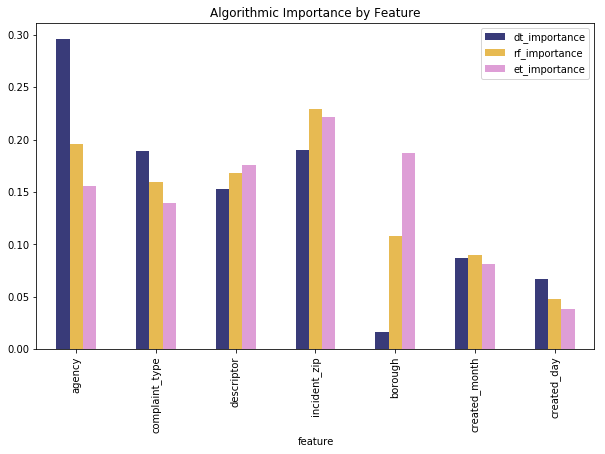

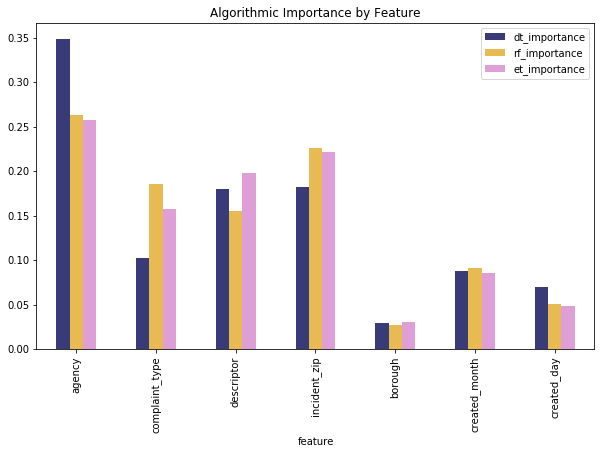

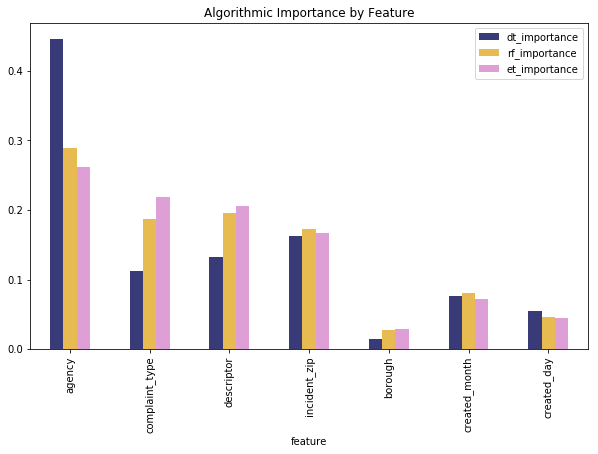

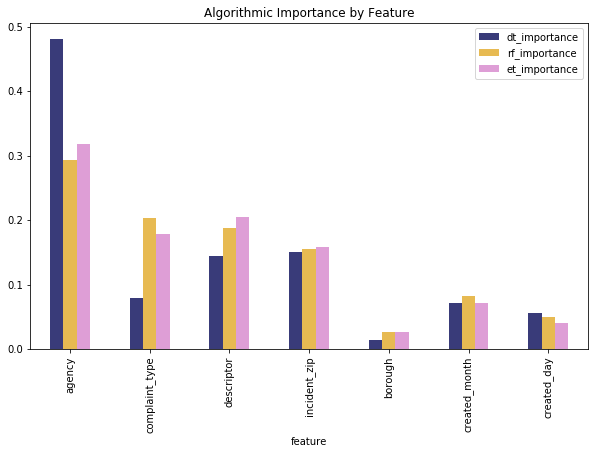

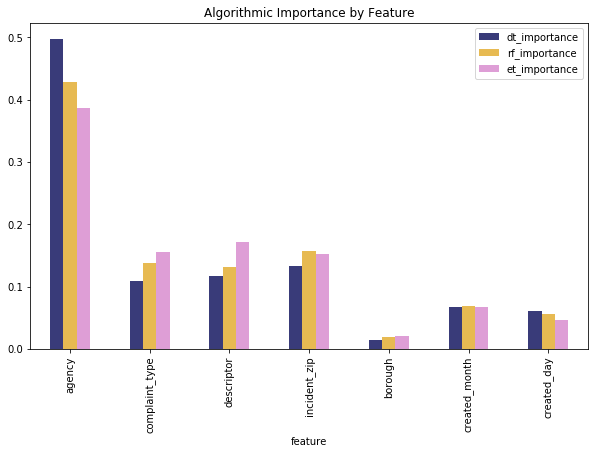

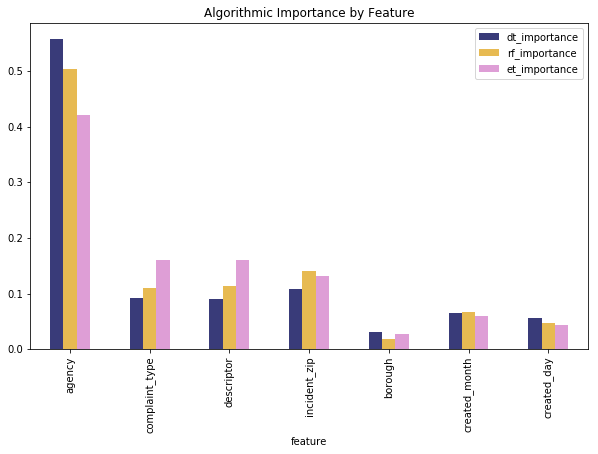

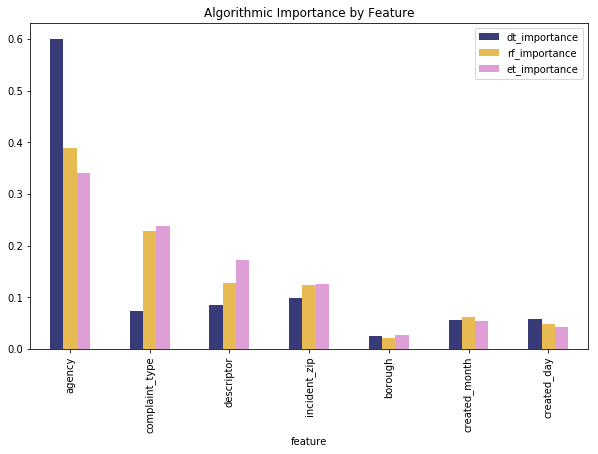

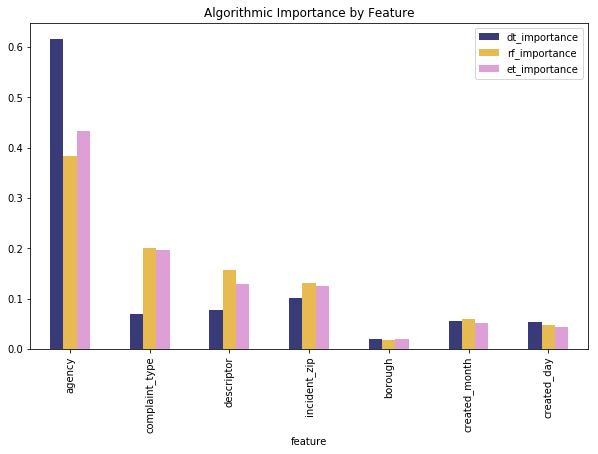

In [129]:
counter = 2009
query_list = ["SELECT created_date, closed_date, agency, complaint_type, descriptor, incident_zip, borough FROM `bigquery-public-data.new_york.311_service_requests` WHERE status IN ('Closed') AND closed_date IS NOT NULL AND created_date BETWEEN '2010-01-01' and '2011-01-01' LIMIT 1000000",
              "SELECT created_date, closed_date, agency, complaint_type, descriptor, incident_zip, borough FROM `bigquery-public-data.new_york.311_service_requests` WHERE status IN ('Closed') AND closed_date IS NOT NULL AND created_date BETWEEN '2011-01-01' and '2012-01-01' LIMIT 1000000",
              "SELECT created_date, closed_date, agency, complaint_type, descriptor, incident_zip, borough FROM `bigquery-public-data.new_york.311_service_requests` WHERE status IN ('Closed') AND closed_date IS NOT NULL AND created_date BETWEEN '2012-01-01' and '2013-01-01' LIMIT 1000000",
              "SELECT created_date, closed_date, agency, complaint_type, descriptor, incident_zip, borough FROM `bigquery-public-data.new_york.311_service_requests` WHERE status IN ('Closed') AND closed_date IS NOT NULL AND created_date BETWEEN '2013-01-01' and '2014-01-01' LIMIT 1000000",
              "SELECT created_date, closed_date, agency, complaint_type, descriptor, incident_zip, borough FROM `bigquery-public-data.new_york.311_service_requests` WHERE status IN ('Closed') AND closed_date IS NOT NULL AND created_date BETWEEN '2014-01-01' and '2015-01-01' LIMIT 1000000",
              "SELECT created_date, closed_date, agency, complaint_type, descriptor, incident_zip, borough FROM `bigquery-public-data.new_york.311_service_requests` WHERE status IN ('Closed') AND closed_date IS NOT NULL AND created_date BETWEEN '2015-01-01' and '2016-01-01' LIMIT 1000000",
              "SELECT created_date, closed_date, agency, complaint_type, descriptor, incident_zip, borough FROM `bigquery-public-data.new_york.311_service_requests` WHERE status IN ('Closed') AND closed_date IS NOT NULL AND created_date BETWEEN '2016-01-01' and '2017-01-01' LIMIT 1000000",
              "SELECT created_date, closed_date, agency, complaint_type, descriptor, incident_zip, borough FROM `bigquery-public-data.new_york.311_service_requests` WHERE status IN ('Closed') AND closed_date IS NOT NULL AND created_date BETWEEN '2017-01-01' and '2018-01-01' LIMIT 1000000"]
df_features = pd.DataFrame()


for q in query_list:
    project = "spheric-crow-161317"
    sample_query = q
    df = read_gbq(query=sample_query, project_id=project, dialect='standard')
#creating counter so that we may know what year we're querying
    counter += 1
    print ' '
    print '-----------------------------------'
    print '-----------------------------------'
    print('YEAR: '+ str(counter))
#modeling the data
    features = modeling(df)
#appending the feature importances to a larger features dataframe
    df_features = df_features.append(features)
    counter
    df_features

                    mean
feature                 
agency          0.382005
complaint_type  0.153756
descriptor      0.151516
incident_zip    0.156980
borough         0.033437
created_month   0.071486
created_day     0.050820


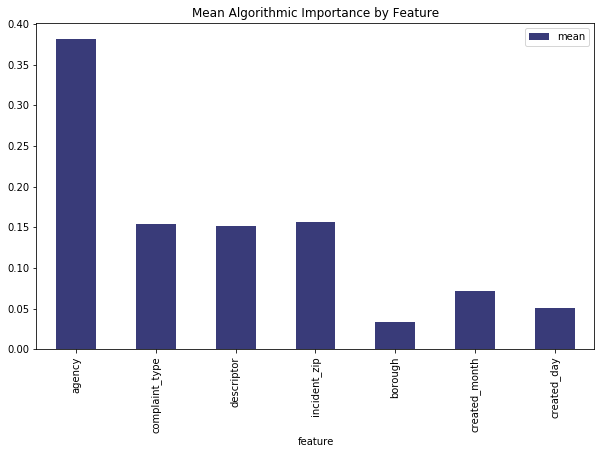

In [141]:
#looking at the mean algorithmic importance for each feature over time

features_mean = df_features.mean()
df_features2 = df_features.T
df_features2['mean'] = features_mean
df_features2 = df_features2[['mean']]
print(df_features2)
df_features2.plot(kind='bar', colormap='tab20b', title='Mean Algorithmic Importance by Feature', figsize = (10,6));

## Agency is always the most important feature, followed by complaint type, incident_zip and descriptor. The importance of features besides Agency seems to diminish over time. Borough, for instance, was a bigger determining factor in 2010 but in later years was relatively unimportant. Above, we can see the mean importance of each feature, determined by our best-performing algorithms. 

# 2 Are rat sightings more common in areas that have a higher density of restaurants with low inspection grades?

In [2]:
#importing all of the rat sightings

project = "spheric-crow-161317"
sample_query = "SELECT unique_key, created_date, closed_date, incident_zip, borough, city, latitude, longitude, location FROM `bigquery-public-data.new_york.311_service_requests` WHERE descriptor IN ('Rat Sighting')"

dfr = read_gbq(query=sample_query, project_id=project, dialect='standard')

Requesting query... ok.
Job ID: job_13BUKzORumrQIa940JtXoHNeZoDB
Query running...
Query done.
Processed: 1.9 GB
Standard price: $0.01 USD

Retrieving results...
  Got page: 1; 36.0% done. Elapsed 10.71 s.
  Got page: 2; 72.0% done. Elapsed 16.27 s.
  Got page: 3; 100.0% done. Elapsed 20.95 s.
Got 107316 rows.

Total time taken 24.49 s.
Finished at 2018-03-13 16:20:47.


In [4]:
#the dataset is comprehensive and up to date

print(dfr['created_date'].min())
print(dfr['created_date'].max())

2010-01-01 08:29:58
2018-01-24 01:40:10


In [3]:
#pivoting rat sighting by borough

rat_boro = dfr.groupby(['borough']).count().sort_values(by = 'unique_key', ascending=False)
rat_boro = rat_boro[['unique_key']]
rat_boro = rat_boro.reset_index()
rat_boro.columns = ['borough', 'rat_sightings']
rat_boro = rat_boro[0:5]
rat_boro

,borough,rat_sightings
0,BROOKLYN,36686
1,MANHATTAN,28133
2,BRONX,21817
3,QUEENS,15567
4,STATEN ISLAND,5108


In [5]:
#pivoting rat sightings by zipcode

rat_zip = dfr.groupby(['incident_zip']).count().sort_values(by = 'unique_key', ascending=False)
rat_zip = rat_zip[['unique_key']]
rat_zip = rat_zip.reset_index()
rat_zip.columns = ['zip', 'rat_sightings']
rat_zip['zip'] = rat_zip['zip'].astype(str)
rat_zip.head()

,zip,rat_sightings
0,11221,3249
1,11216,2619
2,10025,2417
3,11238,2348
4,11233,2011


In [6]:
#reading restaurant grades csv

rg = pd.read_csv("NYC_Restaurant_Grades.csv")

In [7]:
#converting inspection date to datetime

rg['INSPECTION DATE'] = pd.to_datetime(rg['INSPECTION DATE'])

#examining inspection dates

print(rg['INSPECTION DATE'].min())
print(rg['INSPECTION DATE'].max())

1900-01-01 00:00:00
2018-02-27 00:00:00


In [8]:
#bounding inspection dates to be equivalent to the roadent sighting information

rg = rg[(rg['INSPECTION DATE'] >= '2010-01-01') & (rg['INSPECTION DATE'] <= '2018-01-24')]

In [73]:
print(rg['INSPECTION DATE'].min())
print(rg['INSPECTION DATE'].max())

2012-06-23 00:00:00
2018-01-24 00:00:00


In [9]:
#get rid of unnecessary columns

rg = rg[['BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'SCORE', 'GRADE']]
rg2 = rg[['BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'GRADE']]

#drop NAs

rg2 = rg2.dropna()

#focus on restaurants with ABC grades

rg2 = rg2[rg2['GRADE'].str.contains('A|B|C')==True]

### For the purpose of this exercise, I'm defining "low restaurant grades" as "C". 

In [10]:
rg2.head()

,BORO,BUILDING,STREET,ZIPCODE,GRADE
0,BROOKLYN,102,SARATOGA AVE,11233.0,B
1,QUEENS,9640,QUEENS BOULEVARD,11374.0,C
4,QUEENS,15428,NORTHERN BLVD,11354.0,A
5,BROOKLYN,873,FLATBUSH AVENUE,11226.0,A
6,MANHATTAN,2,PARK AVENUE,10016.0,A


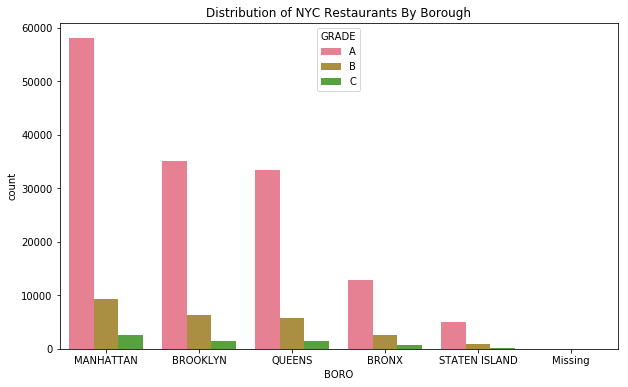

In [11]:
fig, ax = plt.subplots(figsize=(10,6))
sns.set_palette("husl")
order1 = ['MANHATTAN', 'BROOKLYN', 'QUEENS', "BRONX", "STATEN ISLAND", "Missing"]
hue_order1 = ['A', 'B', 'C']
sns.countplot(x='BORO', data=rg2, order=order1, hue="GRADE", hue_order = hue_order1).set_title("Distribution of NYC Restaurants By Borough"); 

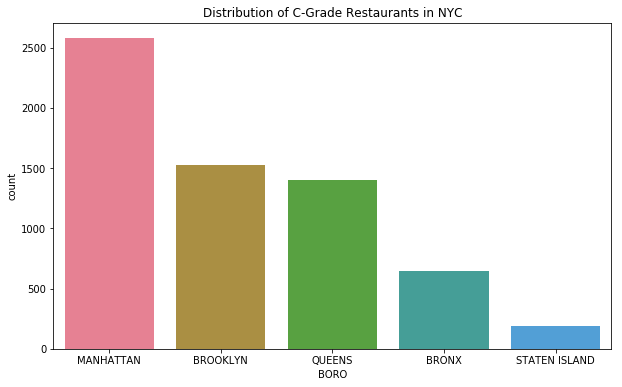

In [12]:
#zooming in to look at the distribution of C-grade restaurants in NYC by borough

rg2_c = rg2[rg2['GRADE'] == 'C']
fig, ax = plt.subplots(figsize=(10,6))
sns.set_palette("husl")
order2 = ['MANHATTAN', 'BROOKLYN', 'QUEENS', "BRONX", "STATEN ISLAND"]
sns.countplot(x="BORO", data=rg2_c, order=order2).set_title("Distribution of C-Grade Restaurants in NYC"); 

## Restaurants seem to maintain the same distribution patterns of A through C grades in each borough. Manhattan has the most followed by Queens and Brooklyn with Brooklyn slightly higher than queens. That's followed by Bronx and Staten Island.

In [13]:
#making pivot table to get # of graded restaurants by boro

by_boro1 = rg2.groupby(['BORO']).count().sort_values(by = 'STREET', ascending=False)
by_boro1 = by_boro1[['BUILDING']]
by_boro1 = by_boro1.reset_index()
by_boro1.columns = ['borough', 'number_of_graded_restaurants']
by_boro1 = by_boro1[0:5]

#making pivot table to get number of graded restaurants by grade in borough

by_boro = rg2.groupby(['BORO', 'GRADE']).count().sort_values(by = 'STREET', ascending=False)
by_boro = by_boro[['BUILDING']]
by_boro = by_boro.reset_index()
by_boro.columns = ['borough', 'grade', 'number_of_grades']
by_boro = by_boro[0:15]

#merging the dataframes to get grades and ratio of grades overall by borough

by_boro = pd.merge(by_boro, by_boro1, how='outer', on='borough')
by_boro['%_X_grade'] = by_boro.number_of_grades/by_boro.number_of_graded_restaurants
by_boro['%_X_grade'] = (by_boro['%_X_grade'] * 100).round(2)

#merging that dataframe with rat dataframe to add rat sightings by borough

health_rats = pd.merge(by_boro, rat_boro, how='outer', on='borough')

#sorting by % of ABC grades in each borough

health_rats = health_rats.sort_values(by='%_X_grade', ascending=False)
health_rats

,borough,grade,number_of_grades,number_of_graded_restaurants,%_X_grade,rat_sightings
0,MANHATTAN,A,58011,69930,82.96,28133
6,QUEENS,A,33377,40538,82.34,15567
12,STATEN ISLAND,A,5018,6125,81.93,5108
3,BROOKLYN,A,35028,42854,81.74,36686
9,BRONX,A,12796,15989,80.03,21817
10,BRONX,B,2545,15989,15.92,21817
13,STATEN ISLAND,B,918,6125,14.99,5108
4,BROOKLYN,B,6299,42854,14.70,36686
7,QUEENS,B,5757,40538,14.20,15567
1,MANHATTAN,B,9340,69930,13.36,28133


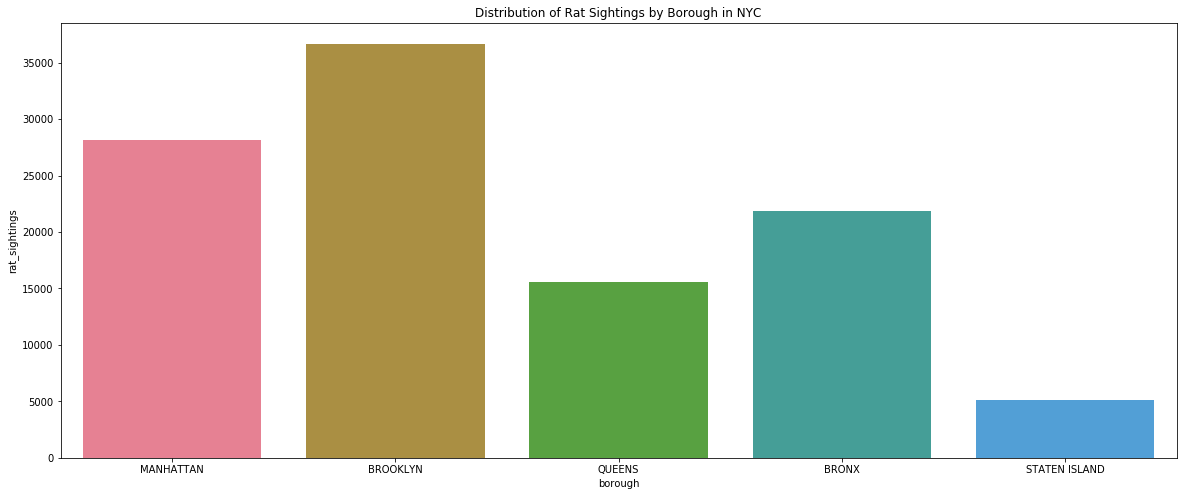

In [14]:
fig, ax = plt.subplots(figsize=(20,8))
sns.set_palette("husl")
#ax.set_xticklabels('%_C_grades', rotation=90)
sns.barplot(x='borough', y='rat_sightings', data=health_rats, order=order2).set_title('Distribution of Rat Sightings by Borough in NYC');

In [15]:
#sorting by rat sightings

health_rats.sort_values(by='rat_sightings', ascending=False)

,borough,grade,number_of_grades,number_of_graded_restaurants,%_X_grade,rat_sightings
3,BROOKLYN,A,35028,42854,81.74,36686
4,BROOKLYN,B,6299,42854,14.70,36686
5,BROOKLYN,C,1527,42854,3.56,36686
0,MANHATTAN,A,58011,69930,82.96,28133
1,MANHATTAN,B,9340,69930,13.36,28133
2,MANHATTAN,C,2579,69930,3.69,28133
9,BRONX,A,12796,15989,80.03,21817
10,BRONX,B,2545,15989,15.92,21817
11,BRONX,C,648,15989,4.05,21817
6,QUEENS,A,33377,40538,82.34,15567


## Rat Sightings don't seem to correspond to lower restaurant scores, by borough. Brooklyn and Bronx have higher rat sightings and almost the same proportion of A grade restaurants (80-82%) and C grade restaurants (3-4%) as other boroughs. Brooklyn, in fact, has a slightly lower percent of C-restaurants than Manhattan. Bronx has slightly more C-grades, but by less than 1%.

## By Borough, the places with the most rat sightings also have the highest proportions of A-graded restaurants. By Borough, restaurants follow the same distribution of high and low-graded restaurants, irrespective of rat sightings. 

## Let's dive in and look by zipcode

In [16]:
#basically the same code as above
#pythonically, I'm supposed to make this into a function but I'm not going to use it again
#and it didn't work out that way when I was writing this analysis in the first place

by_zip1 = rg2.groupby(['ZIPCODE']).count().sort_values(by = 'STREET', ascending=False)
by_zip1 = by_zip1[['BUILDING']]
by_zip1 = by_zip1.reset_index()
by_zip1.columns = ['zip', 'number_of_graded_restaurants']
by_zip1['zip'] = by_zip1['zip'].astype(int).astype(str)

by_zip = rg2.groupby(['ZIPCODE', 'GRADE']).count().sort_values(by = 'STREET', ascending=False)
by_zip = by_zip[['BUILDING']]
by_zip = by_zip.reset_index()
by_zip.columns = ['zip', 'grade', 'number_of_grades']
by_zip['zip'] = by_zip['zip'].astype(int).astype(str)

by_zip = pd.merge(by_zip, by_zip1, how='outer', on='zip')
by_zip['%_X_grade'] = ((by_zip.number_of_grades/by_zip.number_of_graded_restaurants)*100).round(2)
by_zip

health_rats2 = pd.merge(by_zip, rat_zip, how='outer', on='zip')
health_rats2['rat_sightings'] = health_rats2['rat_sightings'].fillna(value=0)
health_rats2 = health_rats2.dropna()

#this one is sorted by rat sightings

health_rats2 = health_rats2.sort_values(by='rat_sightings', ascending=False)
health_rats2.head()

,zip,grade,number_of_grades,number_of_graded_restaurants,%_X_grade,rat_sightings
264,11221,A,569.0,746.0,76.27,3249.0
265,11221,B,158.0,746.0,21.18,3249.0
266,11221,C,19.0,746.0,2.55,3249.0
184,11216,B,177.0,1030.0,17.18,2619.0
183,11216,A,833.0,1030.0,80.87,2619.0


## Looking at the full healthrats2 dataframe, you can see that even in the zipcodes with the highest number of rat sightings, the distribution of A through C grade restaurants in that zipcode is very similarly distributed to the distribution of the Borough analysis: 75-85% A's and 2-5% C's. There is however,  a bit more grade variation here than in the Borough analysis. There are also more restaurants total associated with more rat sightings. 

## The original questions asked about rat sightings in areas of higher restaurant concentration with lower grades, so we're going to look at restaurants with C-grades in zipcodes where the number of total restaurants is greater than the median number of restaurants per zipcode. We're going to look at rat sightings in these zipcodes and compare it to it's A-grade counterpart.

In [17]:
#using median as a measure here because the distribution isn't normal

health_rats_0 = pd.merge(by_zip1, rat_zip, how='outer', on='zip')
print("median number of graded restaurants per zip: "+ str(health_rats_0['number_of_graded_restaurants'].median()))
print("median rat sightings per zip: "+ str((health_rats_0['rat_sightings'].median())))

median number of graded restaurants per zip: 531.5
median rat sightings per zip: 361.0


In [18]:
#looking at zipcodes sorted by higher to lower restaurant C-grade concentrations where
#the number of total restaurants in that zipcode is greater or equal to the mean

c_zip = health_rats2[health_rats2['grade'] == 'C'].sort_values(by='%_X_grade', ascending=False)
c_zip = c_zip[c_zip['number_of_graded_restaurants'] >= 531]
c_zip.columns = ['zip', 'grade', 'number_of_C_grades', "number_of_graded_restaurants", "%_C_grades", "rat_sightings"]
print('Median rat sightings per Zip for C-Grade Restaurants in high restaurant density zips: ' + str(c_zip['rat_sightings'].median()))
print('Median C Grade % of restaurants in high restaurant density zips '+ str(c_zip['%_C_grades'].median()))
c_zip.head()

Median rat sightings per Zip for C-Grade Restaurants in high restaurant density zips: 594.0
Median C Grade % of restaurants in high restaurant density zips 3.435


,zip,grade,number_of_C_grades,number_of_graded_restaurants,%_C_grades,rat_sightings
353,10454,C,66.0,544.0,12.13,571.0
361,10035,C,46.0,550.0,8.36,801.0
281,10452,C,59.0,731.0,8.07,1234.0
230,11236,C,65.0,863.0,7.53,616.0
113,11237,C,102.0,1406.0,7.25,1432.0


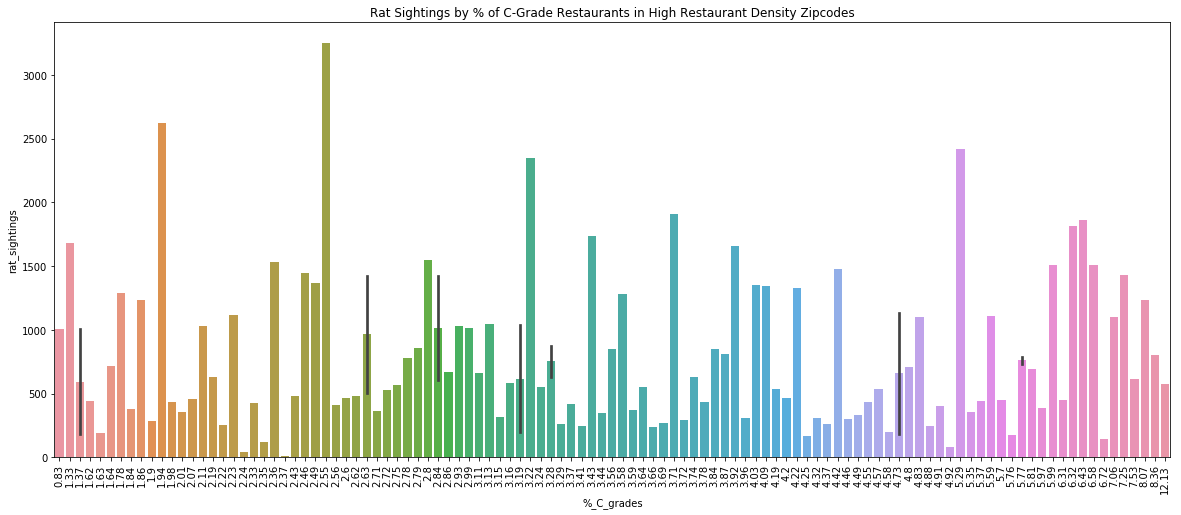

In [19]:
fig, ax = plt.subplots(figsize=(20,8))
sns.set_palette("husl")
ax.set_xticklabels('%_C_grades', rotation=90)
#sns.regplot(x='%_C_grades', y='rat_sightings', data=c_zip)
sns.barplot(x='%_C_grades', y='rat_sightings', data=c_zip).set_title("Rat Sightings by % of C-Grade Restaurants in High Restaurant Density Zipcodes");

LinregressResult(slope=6.823318672041515, intercept=765.6225444516645, rvalue=0.020135891449308177, pvalue=0.8301234029139767, stderr=31.73104001157391)


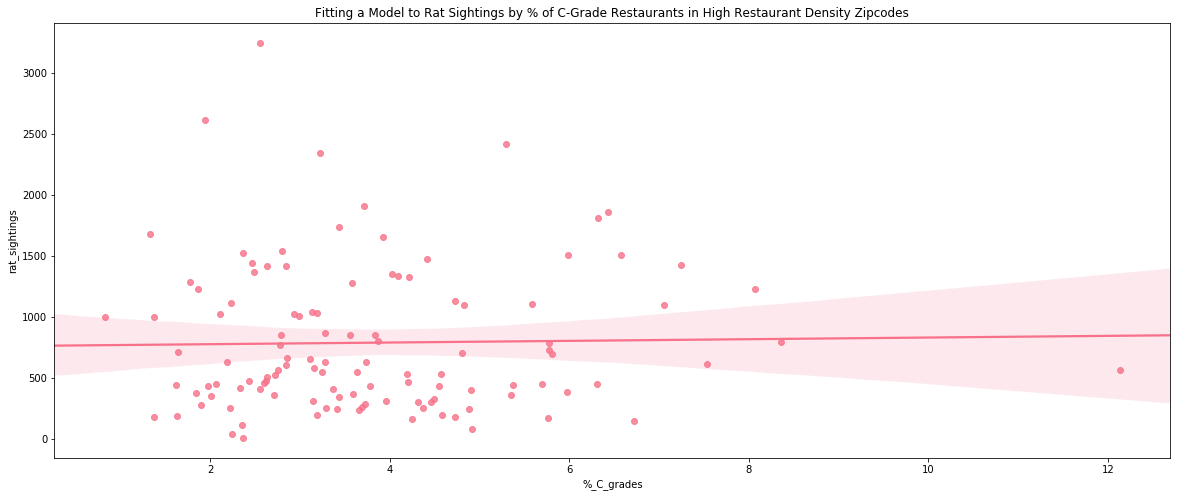

In [21]:
#let's visualize the relationship between % of C grades and rat sightings and predict a model

print(linregress(c_zip['%_C_grades'], c_zip['rat_sightings']))
fig, ax = plt.subplots(figsize=(20,8))
sns.set_palette("husl")
sns.regplot(x='%_C_grades', y='rat_sightings', data=c_zip).set_title("Fitting a Model to Rat Sightings by % of C-Grade Restaurants in High Restaurant Density Zipcodes");

## The slope of this line is 6.82, meaning that there are ~7 more rat sightings for every 1% increase in C-grades. That said, the rvalue=0.02, which means rat sightings and the % of C-grades in a zipcode are very weakly correlated and the significance is p=0.83 which means this is not statistically significant. Also, the standard error is rather high at 31.73.

## In high density restaurant zipcodes, as the % of C-grade restaurants increases, the number of rat sightings basically stays the same. We suspect rat sightings aren't significantly more common in areas with a higher density of restaurants with low inspection grades, but we can't really know for sure with this data.

In [22]:
a_zip = health_rats2[health_rats2['grade'] == 'A'].sort_values(by='%_X_grade', ascending=False)
a_zip = a_zip[a_zip['number_of_graded_restaurants'] >= 531]
a_zip.columns = ['zip', 'grade', 'number_of_A_grades', "number_of_graded_restaurants", "%_A_grades", "rat_sightings"]
print('Median rat sightings per Zip for A-Grade Restaurants in high restaurant density zips: ' + str(a_zip['rat_sightings'].median()))
print('Median A Grade % of restaurants in high restaurant density zips '+ str(a_zip['%_A_grades'].median()))
a_zip.head()

Median rat sightings per Zip for A-Grade Restaurants in high restaurant density zips: 594.0
Median A Grade % of restaurants in high restaurant density zips 81.71


,zip,grade,number_of_A_grades,number_of_graded_restaurants,%_A_grades,rat_sightings
87,11103,A,1254.0,1400.0,89.57,457.0
114,10023,A,1084.0,1216.0,89.14,809.0
138,11106,A,1029.0,1155.0,89.09,284.0
276,10075,A,559.0,629.0,88.87,241.0
66,11209,A,1561.0,1760.0,88.69,256.0


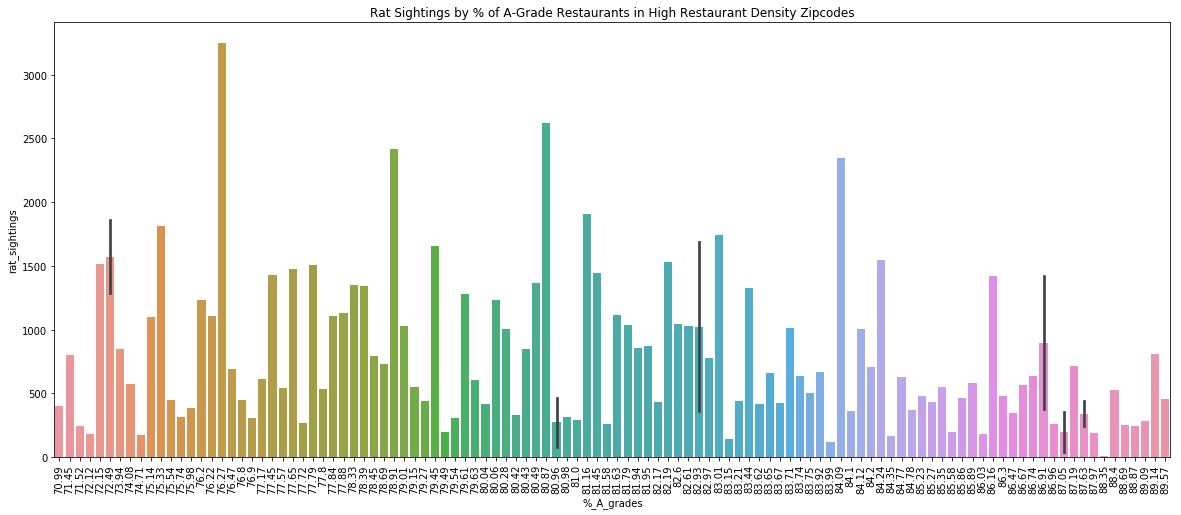

In [23]:
fig, ax = plt.subplots(figsize=(20,8))
sns.set_palette("husl")
ax.set_xticklabels('%_A_grades', rotation=90)
sns.barplot(x='%_A_grades', y='rat_sightings', data=a_zip).set_title("Rat Sightings by % of A-Grade Restaurants in High Restaurant Density Zipcodes");

LinregressResult(slope=-33.8110456260183, intercept=3543.680851629978, rvalue=-0.2612285104137399, pvalue=0.004619955777636569, stderr=11.70139272186573)


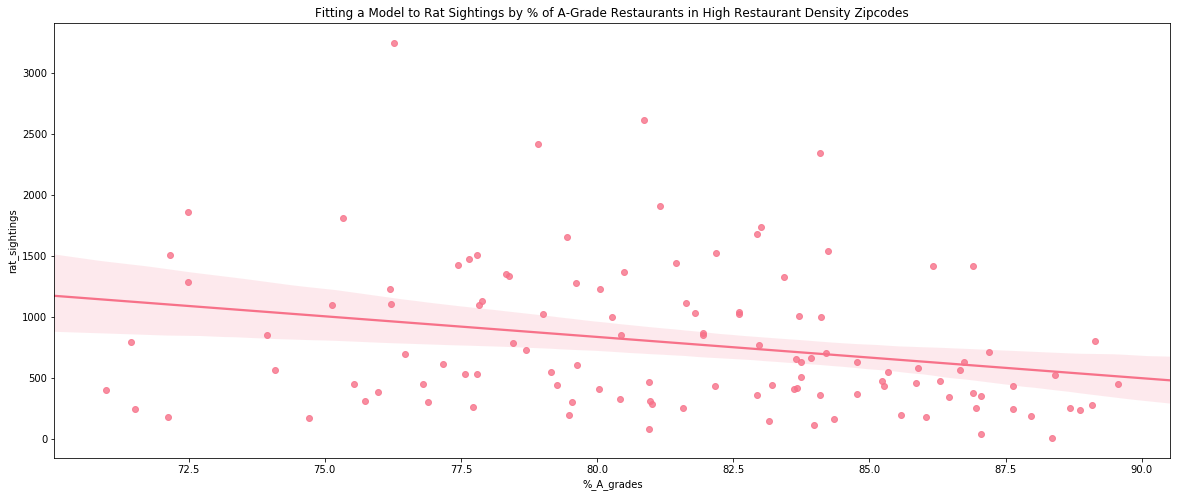

In [24]:
#Let's look at the diference between A and C model

print(linregress(a_zip['%_A_grades'], a_zip['rat_sightings']))
fig, ax = plt.subplots(figsize=(20,8))
sns.set_palette("husl")
sns.regplot(x='%_A_grades', y='rat_sightings', data=a_zip).set_title("Fitting a Model to Rat Sightings by % of A-Grade Restaurants in High Restaurant Density Zipcodes");

## The slope of this line is -33.81, meaning that there are ~34 fewer rat sightings for every 1% increase in A-grades. That said, the rvalue=-0.26, which means rat sightings and the % of C-grades in a zipcode have a negative and low correlation. The significance is p=0.005 which means this is statistically significant. The standard error is reasonable 11.70, so we can reasonably trust these figures.

## In high density restaurant zipcodes, we can be faily certain that as the % of A-grade restaurants increase, rat sightings decrease. As the % of C-grade restaurants increases, rat sightings seem to barely change, but we can't know for sure because the results are insignificant.

## Conclusion: We don't really know if rat sightings aren't significantly more common in areas with a higher density of restaurants with low inspection grades. The distribution of restaurant grades stays fairly uniform in all areas and rat sightings only seems to increase/decrease according to the percentage of A-grade restaurants in high density restaurant zipcodes: fewer rat sightings = more A-grade restaurants, more rat sightings = fewer A-grade restaurants. In this exercise I'm defining a "low" grade as "C".

# Pick another 2 topics:

### 1. How do rat sightings correspond to actual rat populations? I'd solve this by bringing in the NYC Open Data Roadent Inspection table <https://data.cityofnewyork.us/Health/Rodent-Inspection/p937-wjvj> to look at actual rodent inspections. I'd contrast this to the rat sightings data in the NYC 311 table and visualize the relationship. If I had unlimited time, I'd probably use Tableau and GeoPandas to map it out by latitude and longitude. I'd expect a higher incidence of rat sightings in more populated loactions, regardless of actual rodent populations. 

### 2. What is the most popular kind of restaurant in NYC by cuisine? I'm going to solve this with a bar chart and the Restaurant Grades data.

In [39]:
#reading csv

rg = pd.read_csv("NYC_Restaurant_Grades.csv", encoding='utf-8')
rg = rg.dropna()

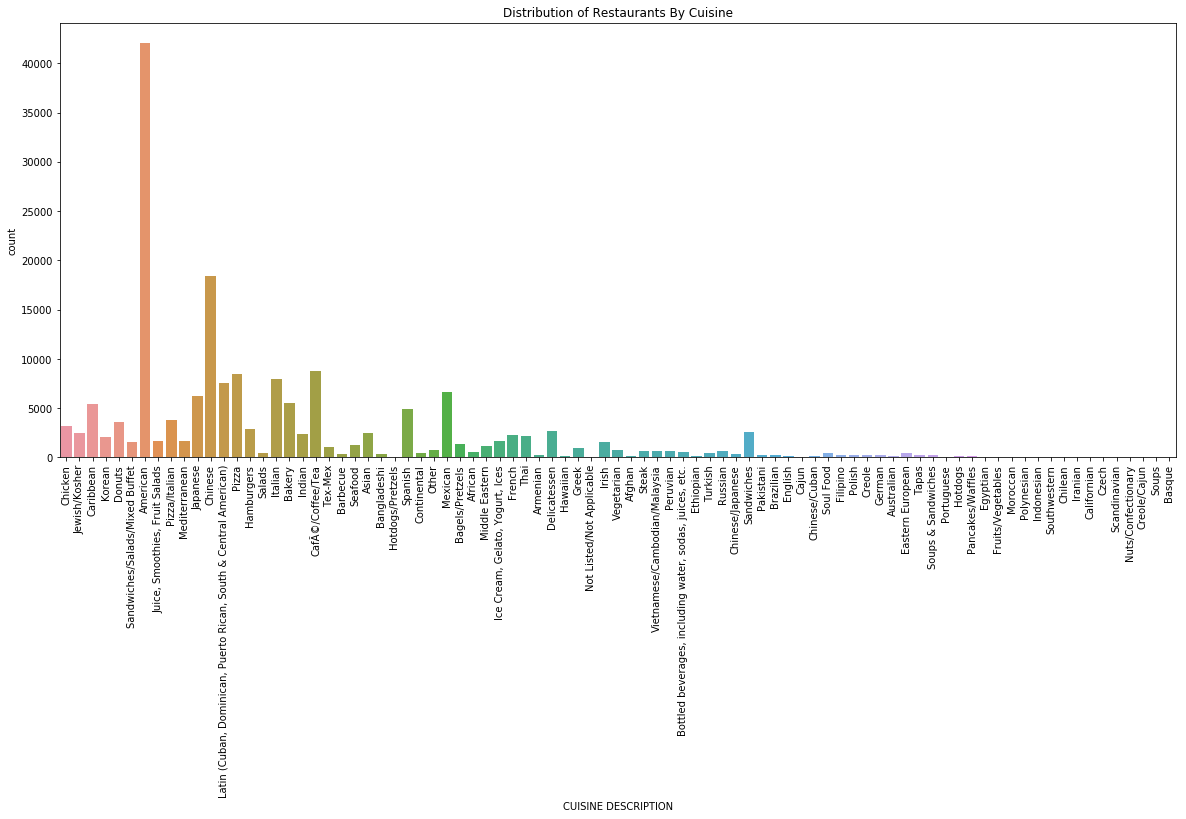

In [45]:
#plotting cuisine types

fig, ax = plt.subplots(figsize=(20,8))
sns.set_palette("husl")
ax.set_xticklabels('%_A_grades', rotation=90)
sns.countplot(x='CUISINE DESCRIPTION', data=rg, hue_order = hue_order1).set_title("Distribution of Restaurants By Cuisine"); 

### The most common restaurant types in NYC are "American" followed by "Chinese" with "Cafes/Coffee/Tea" and "Pizza" as a close 3rd and 4th.